In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
card_df = pd.read_csv("creditcard.csv")

In [2]:
card_df.shape

(284807, 31)

In [3]:
from sklearn.model_selection import train_test_split
# 우선 time feature은 필요 없다
def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop("Time", axis = 1, inplace = True)
    return df_copy

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print(y_train.value_counts() / y_train.shape[0])
print(y_test.value_counts() / y_test.shape[0])
y_test.shape

0    0.998275
1    0.001725
Name: Class, dtype: float64
0    0.998268
1    0.001732
Name: Class, dtype: float64


(85443,)

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, precision_recall_curve, recall_score, roc_auc_score, f1_score
def get_clf_eval(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test, pred).round(4)
    confusion = confusion_matrix(y_test, pred)
    precision = precision_score(y_test, pred).round(4)
    recall = recall_score(y_test, pred).round(4)
    f1 = f1_score(y_test, pred).round(4)
    roc_auc = roc_auc_score(y_test, pred_proba).round(4)
    print("오차행렬")
    print(confusion)
    print("정확도 : {}, 정밀도 : {}, 재현율 : {}, f1 : {}, roc : {}".format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85280    15]
 [   55    93]]
정확도 : 0.9992, 정밀도 : 0.8611, 재현율 : 0.6284, f1 : 0.7266, roc : 0.9698


In [8]:
# 위의 식을 일반화
def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False) # boost_from_average는 불균형한 데이터 셋에서 true이면 roc score와 재현율을 저조하게 한다
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568, f1 : 0.8453, roc : 0.979


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199364, 29), (85443, 29), (199364,), (85443,))

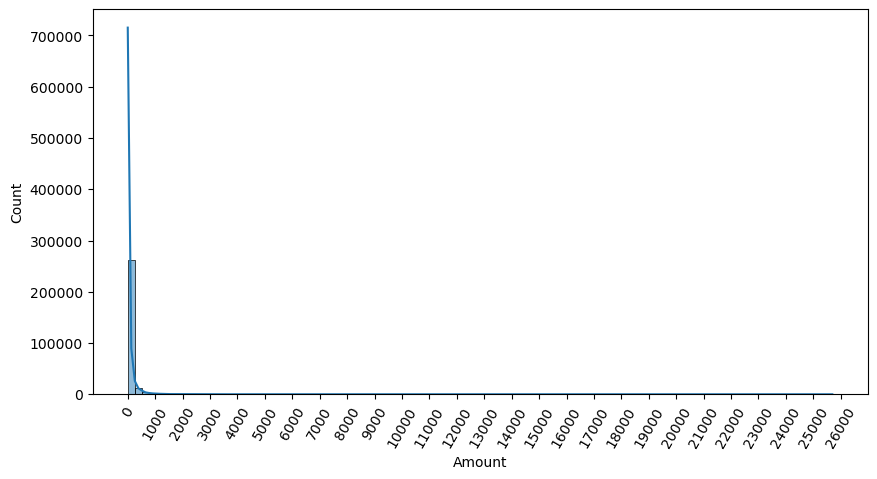

In [11]:
# amount feature는 신용 카드 사용 금액 -> 분류의 중요한 기준
import seaborn as sns
plt.figure(figsize = (10, 5))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.histplot(card_df["Amount"], bins = 100, kde = True)
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy["Amount"].values.reshape(-1,1))
    df_copy.insert(0, "Amount_scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    return df_copy

In [13]:
get_preprocessed_df(card_df)

,Amount_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.350151,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,-0.254117,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,-0.081839,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.313249,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


In [14]:
card_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [15]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [16]:
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081, f1 : 0.7143, roc : 0.9702


In [17]:
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   37   111]]
정확도 : 0.9995, 정밀도 : 0.9569, 재현율 : 0.75, f1 : 0.8409, roc : 0.9779


In [18]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, "Amount_scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    return df_copy

In [19]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_trtain_test_dataset(card_df)

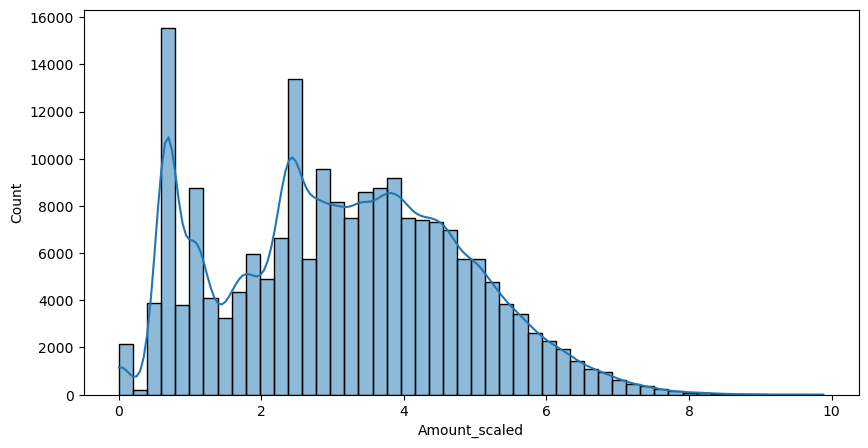

In [20]:
# amount feature는 신용 카드 사용 금액 -> 분류의 중요한 기준
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.histplot(X_train["Amount_scaled"], bins = 50, kde = True)
plt.show()

In [21]:
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)


오차행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율 : 0.6014, f1 : 0.7149, roc : 0.9727


In [22]:
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635, f1 : 0.8496, roc : 0.9796


<AxesSubplot:>

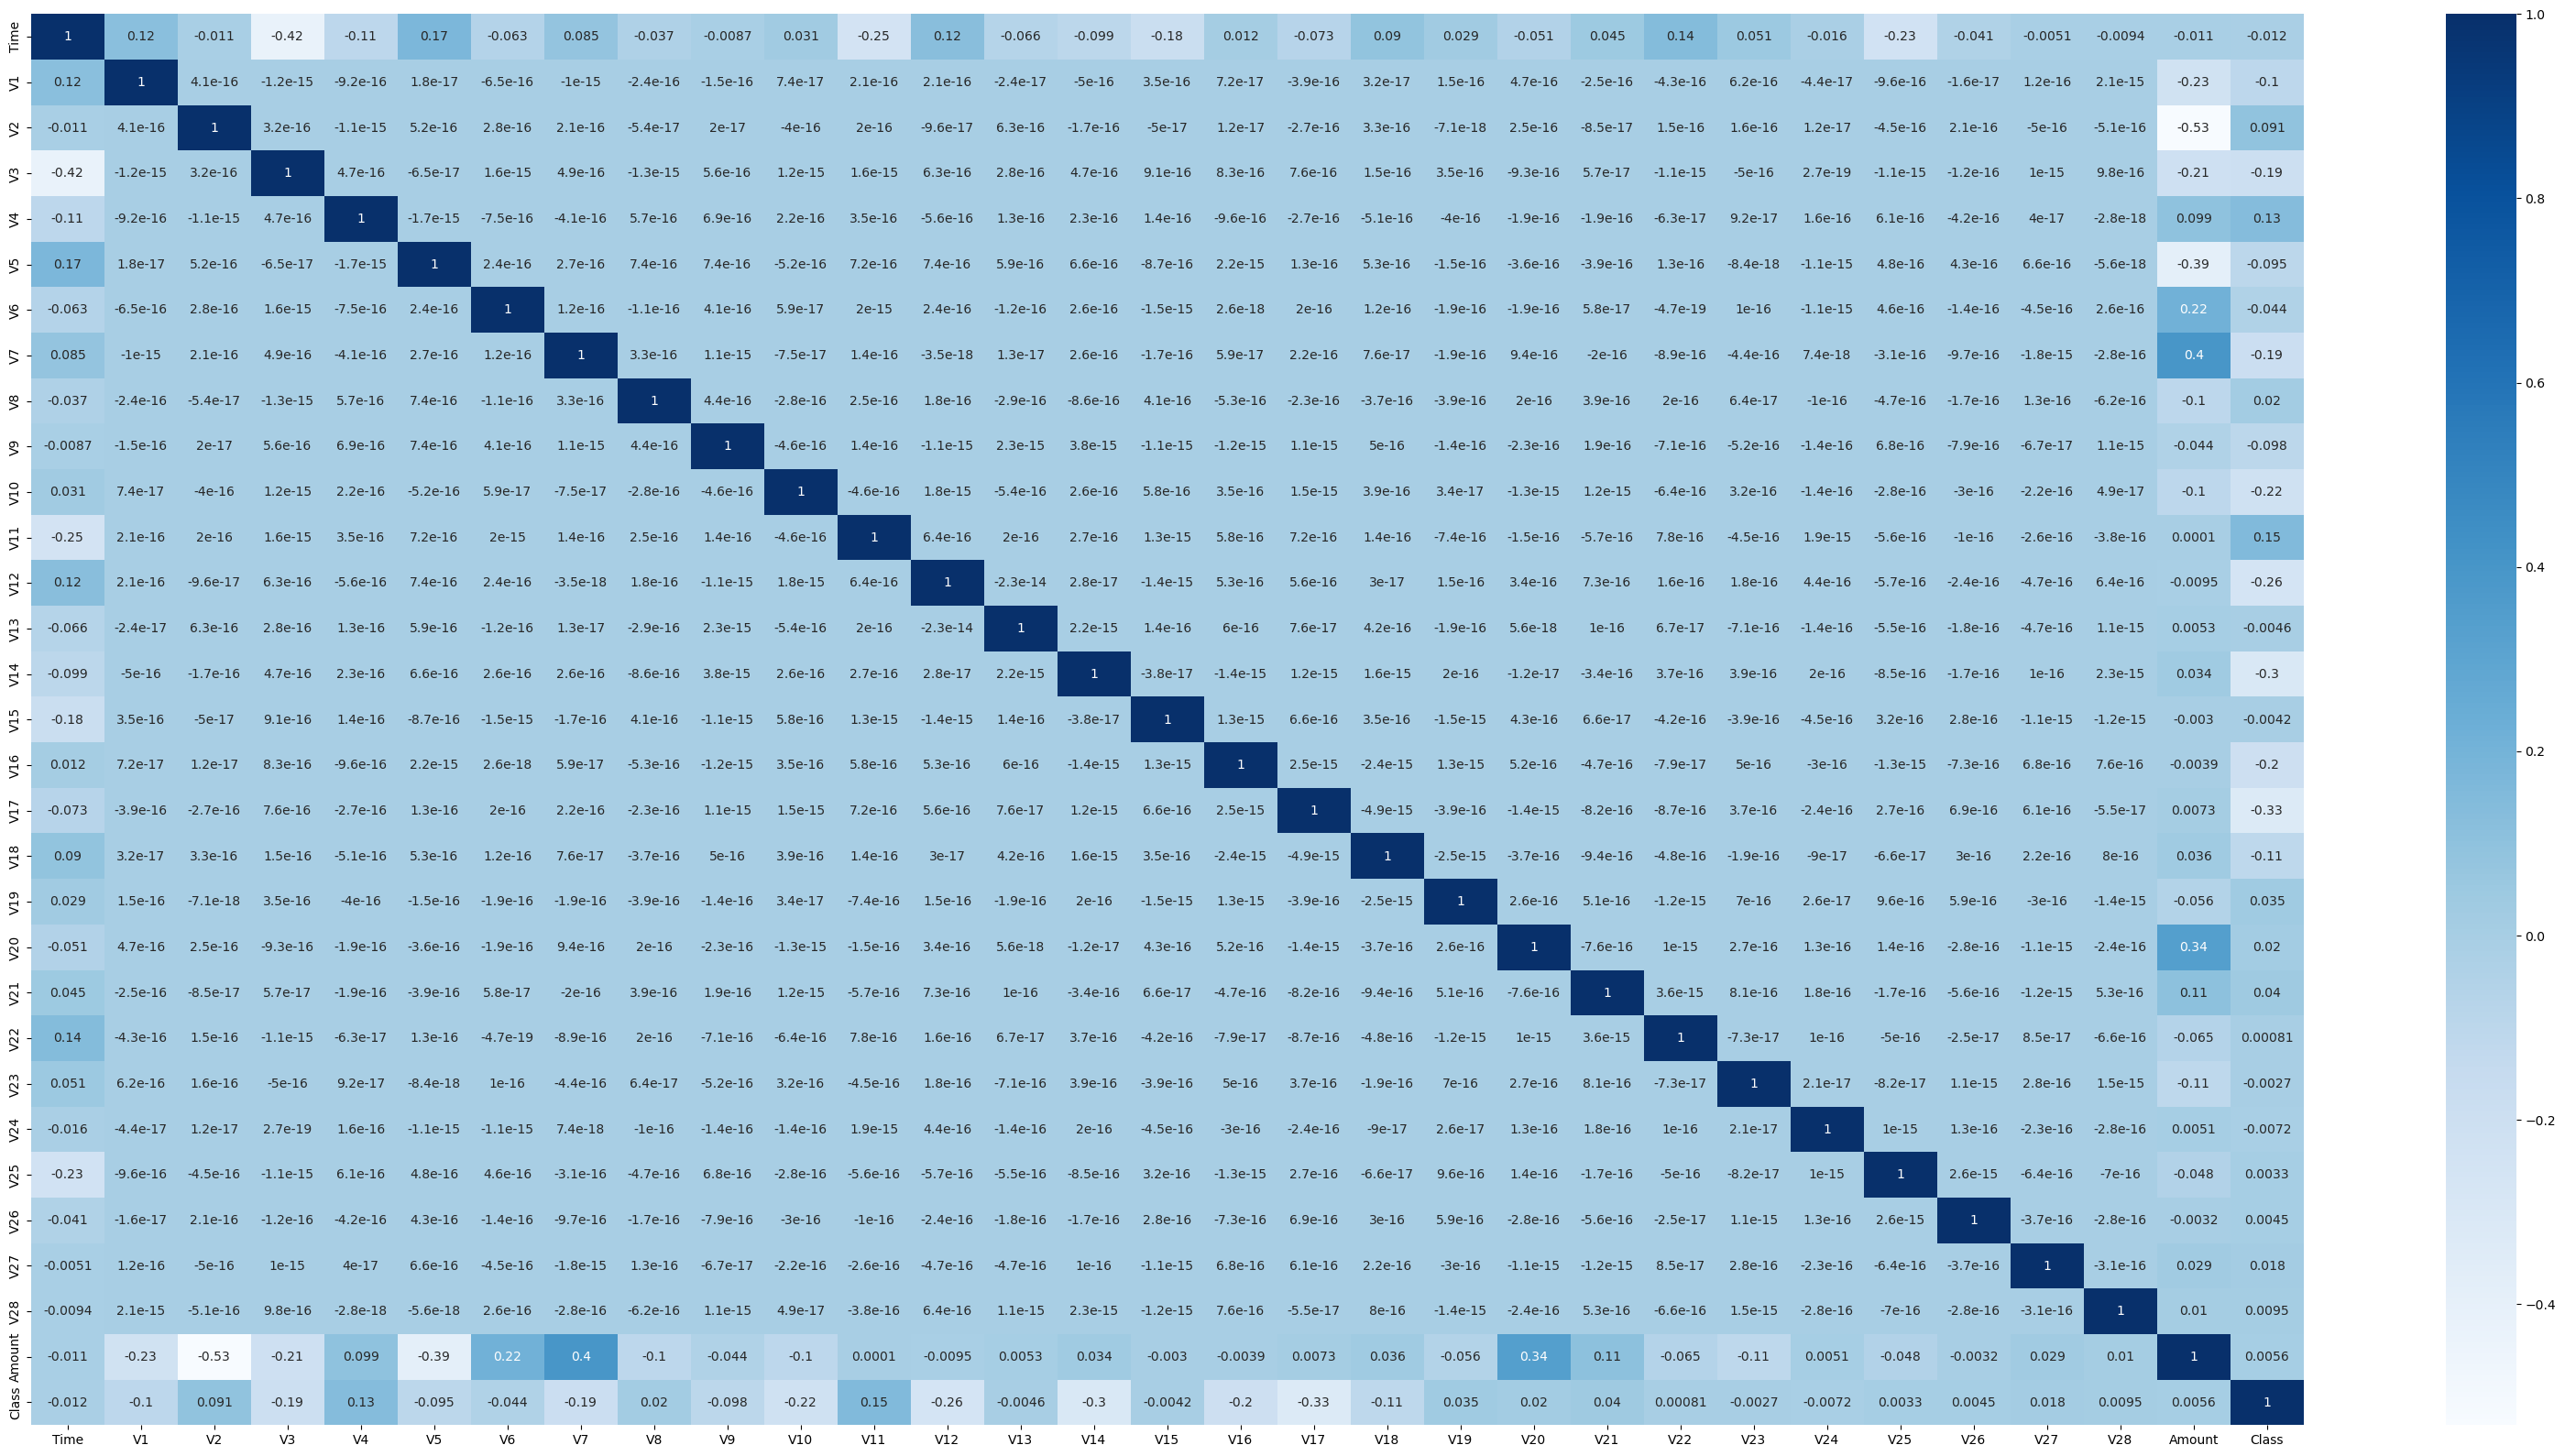

In [23]:
import seaborn as sns
plt.figure(figsize = (40, 20))
sns.heatmap(card_df.corr(), cmap = "Blues", annot = True)

In [24]:
import numpy as np
def get_outlier(df, column, weight):
    fraud = df[df["Class"] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75) # percentile method? 무엇을 반환 하는가?
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    hightest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > hightest_val)].index
    return outlier_index

In [25]:
outlier_ind = get_outlier(card_df, "V14", 1.5)

In [26]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, "Amount_scaled", amount_n)
    df_copy.drop(["Time", "Amount"], axis = 1, inplace = True)
    outlier_index = get_outlier(df_copy,'V14', 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

In [27]:
# 사전 데이터 가공 후 학습과 테스트 데이터 셋을 반환하는 함수
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify = y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [28]:
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.875, 재현율 : 0.6712, f1 : 0.7597, roc : 0.9743


In [29]:
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603, 재현율 : 0.8288, f1 : 0.8897, roc : 0.978


In [30]:
import imblearn

In [31]:
imblearn.__version__

'0.9.1'

In [32]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [33]:
X_train_over.shape, y_train_over.shape

((398040, 29), (398040,))

In [34]:
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.9247, f1 : 0.1023, roc : 0.9737


In [35]:
precision_recall_curve(y_test, lr_clf.predict_proba(X_test)[:, 1])

(array([0.00170878, 0.0017088 , 0.00170882, ..., 0.85555556, 0.85393258,
        1.        ]),
 array([1.        , 1.        , 1.        , ..., 0.52739726, 0.52054795,
        0.        ]),
 array([1.34915881e-32, 8.48544048e-31, 1.17934032e-30, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]))

In [36]:
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.8493, f1 : 0.8794, roc : 0.9814


In [38]:
X_train["Amount_scaled"].value_counts()

0.693147    9542
1.091923    4245
0.636577    3423
2.396986    3359
2.772589    2311
            ... 
4.670396       1
5.167924       1
5.740500       1
5.874903       1
7.480146       1
Name: Amount_scaled, Length: 27431, dtype: int64

In [40]:
X_train["Amount_scaled"].nunique()

27431